In [1]:
import json

with open("train_file.json", 'r') as file:
    train = json.load(file)

# Load the test data
with open("val_file.json", 'r') as file:
    val = json.load(file)

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import string
import nltk
import re



class PreProcessor():
    
    def __init__(self) -> None:
        self.numbers = {
            "0":"zero",
            "1":"one",
            "2":"two",
            "3":"three",
            "4":"four",
            "5":"five",
            "6":"six",
            "7":"seven",
            "8":"eight",
            "9":"nine"
        }
        
    def remove_puntuations(self, txt):
        punct = set(string.punctuation)
        txt = " ".join(txt.split("."))
        txt = " ".join(txt.split("!"))
        txt = " ".join(txt.split("?"))
        txt = " ".join(txt.split(":"))
        txt = " ".join(txt.split(";"))

        txt = "".join(ch for ch in txt if ch not in punct)
        return txt
    
    def number_to_words(self, txt):
        for k in self.numbers.keys():
            txt = txt.replace(k,self.numbers[k]+" ")
        return txt
    
    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'_',' ',text)
        text = self.number_to_words(text)
        text = self.remove_puntuations(text)
        text = ''.join([i if ord(i) < 128 else '' for i in text])
        text = ' '.join(text.split())
        return text


In [4]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np

preprocessor = PreProcessor()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()

def get_embeddings(model , preprocessor , tokenizer , sentences):
    model.to(device)  # Move the model to the same device as the data
    embeddings = []
    for sentence in tqdm(sentences, desc="Computing BERT embeddings"):
        with torch.no_grad():
            sentence = preprocessor.preprocess_text(sentence)
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=64)
            inputs = inputs.to(device)  # Move the inputs to the same device as the model
            outputs = model(**inputs)
            embeddings.append(outputs.pooler_output.squeeze().cpu().numpy())
    return np.array(embeddings)

In [5]:
def prepare_data(data):
    
    emo2idx = {
        'anger': 0,
        'joy': 1,
        'fear': 2,
        'disgust': 3,
        'neutral': 4,
        'surprise': 5,
        'sadness': 6
    }
    
    seq_len = 25
    
    embeddings_utt = get_embeddings(model , preprocessor , tokenizer , [u for episode in tqdm(data, desc="Processing Episodes Data") for u in episode['utterances']])

    X = []
    Y = []
    
    # Process each episode for emotion flips
    for episode in tqdm(data, desc="Processing episodes"):
        episode_utterances = episode['utterances']
        episode_emotions = episode['emotions']

        episode_X, episode_Y = [], []
        previous_emo_idx = None

        for i, (utterance, emotion) in enumerate(zip(episode_utterances, episode_emotions)):
            # Convert utterance to BERT embedding index
            utterance_idx = i  
            
            emo_idx = emo2idx.get(emotion, 4)

            flip = 1 if previous_emo_idx is not None and previous_emo_idx != emo_idx else 0
            previous_emo_idx = emo_idx

            # Append data
            episode_X.append(embeddings_utt[utterance_idx])
            episode_Y.append(flip)

        if len(episode_X) < seq_len:
            padding_length = seq_len - len(episode_X)
            episode_X.extend([np.zeros_like(episode_X[0])] * padding_length)
            episode_Y.extend([0] * padding_length)

        elif len(episode_X) > seq_len:
            episode_X = episode_X[-seq_len:]
            episode_Y = episode_Y[-seq_len:]

        X.append(episode_X)
        Y.append(episode_Y)

    X = torch.FloatTensor(X)  
    Y = torch.FloatTensor(Y) 

    return X.to(device), Y.to(device)

In [6]:
X_train, Y_train = prepare_data(train)
X_test, Y_test = prepare_data(val)

Processing episodes: 100%|██████████| 6740/6740 [00:00<00:00, 135327.33it/s]
/tmp/ipykernel_265434/3999148527.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.FloatTensor(X)
Processing episodes: 100%|██████████| 843/843 [00:00<00:00, 117094.92it/s]


In [7]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, num_layers=2, dropout=0.2):
        super(Model, self).__init__()
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size, input_size, num_layers, 
                              dropout=dropout, bidirectional=False, batch_first=True)
        self.linear = nn.Linear(input_size, hidden_size)
        self.final_linear = nn.Linear(hidden_size, 1)

    def forward(self, text_encoding):
        x = text_encoding.float().squeeze()
        x, _ = self.lstm(x)

        x = self.linear(x)
        x = self.relu(x)
        x = self.final_linear(x)

        x = torch.sigmoid(x)
        return x.squeeze(-1)

In [8]:
model = Model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Model(
  (relu): ReLU()
  (lstm): LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=768, out_features=128, bias=True)
  (final_linear): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
from torch.utils.data import TensorDataset, DataLoader

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
num_epochs = 4


def train(epochs):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, Y_batch in tqdm(train_loader, desc=f"Training: [{epoch+1}/{num_epochs}]"):
            X_batch, Y_batch = X_batch.squeeze().to(device), Y_batch.squeeze().to(device)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_loader)}')
        train_loss.append(loss.item())

        model.eval()
        test_loss = 0
        with torch.no_grad():
            Y_pred = model(X_test.to(device))
            test_loss = criterion(Y_pred, Y_test.to(device))
            val_loss.append(test_loss.item())
            print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {test_loss.item()}")
            
            
    return train_loss, val_loss
            
            
train_loss , val_loss = train(num_epochs)


Training: [1/4]:   0%|          | 0/6740 [00:00<?, ?it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


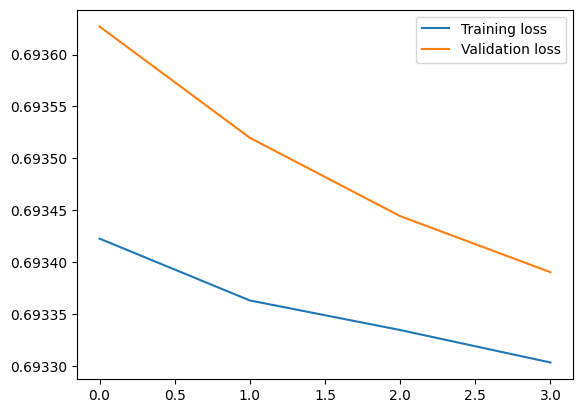

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report   

model.eval()
test_loss = 0
val_loss = []
with torch.no_grad():
    Y_pred = model(X_test.to(device))
    Y_pred_binary = (Y_pred >= 0.5).int()
    test_loss = criterion(Y_pred, Y_test.to(device))
    val_loss.append(test_loss.item())
    Y_test_np = Y_test.cpu().numpy()
    Y_pred_binary_np = Y_pred_binary.cpu().numpy()
    
print(f"Validation Loss: {test_loss.item()}")
print(classification_report(Y_test_np.flatten(), Y_pred_binary_np.flatten()))

Validation Loss: 0.6933902502059937
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88      1977
         1.0       0.00      0.00      0.00       523

    accuracy                           0.79      2500
   macro avg       0.40      0.50      0.44      2500
weighted avg       0.63      0.79      0.70      2500



/Users/parthivdholaria/Desktop/PARTHIV/IIIT DELHI/SEM6/NLP/Assigment 3/nlpa3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/parthivdholaria/Desktop/PARTHIV/IIIT DELHI/SEM6/NLP/Assigment 3/nlpa3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/parthivdholaria/Desktop/PARTHIV/IIIT DELHI/SEM6/NLP/Assigment 3/nlpa3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

In [ ]:
# save the model 

torch.save(model, "lstm_t2.pth")